# 必要な関数

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, DotProduct
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import norm


def gpr_one_kernel(kernel_number,autoscaled_x, autoscaled_y,x):
    # カーネル 11 種類
    kernels = [ConstantKernel() * DotProduct() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel(),
            ConstantKernel() * RBF() + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel(),
            ConstantKernel() * RBF(np.ones(x.shape[1])) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=1.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=0.5) + WhiteKernel() + ConstantKernel() * DotProduct(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel(),
            ConstantKernel() * Matern(nu=2.5) + WhiteKernel() + ConstantKernel() * DotProduct()]

    selected_kernel = kernels[kernel_number]
    model = GaussianProcessRegressor(alpha=0, kernel=selected_kernel)
    model.fit(autoscaled_x, autoscaled_y)

    return model


def validate_model(regression_method, model,fold_number, autoscaled_x, autoscaled_y, x, y):
     # クロスバリデーションの fold 数
    fold_number = fold_number
    
    # トレーニングデータの推定(実験データ)
    autoscaled_estimated_y = model.predict(autoscaled_x)  # y の推定
    estimated_y = autoscaled_estimated_y * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y = pd.DataFrame(estimated_y, index=x.index, columns=['estimated_y'])

    # トレーニングデータの実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # トレーニングデータのr2, RMSE, MAE
    print('r^2 for training data :', r2_score(y, estimated_y))
    print('RMSE for training data :', mean_squared_error(y, estimated_y, squared=False))
    print('MAE for training data :', mean_absolute_error(y, estimated_y))

    # トレーニングデータの結果の保存
    y_for_save = pd.DataFrame(y)
    y_for_save.columns = ['actual_y']
    y_error_train = y_for_save.iloc[:, 0] - estimated_y.iloc[:, 0]
    y_error_train = pd.DataFrame(y_error_train)
    y_error_train.columns = ['error_of_y(actual_y-estimated_y)']
    results_train = pd.concat([y_for_save, estimated_y, y_error_train], axis=1) # 結合
    results_train.to_csv('./../results/validation/estimated_y_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    
    # クロスバリデーションによる y の値の推定
    cross_validation = KFold(n_splits=fold_number, random_state=9, shuffle=True) # クロスバリデーションの分割の設定
    autoscaled_estimated_y_in_cv = cross_val_predict(model, autoscaled_x, autoscaled_y, cv=cross_validation)  # y の推定
    estimated_y_in_cv = autoscaled_estimated_y_in_cv * y.std() + y.mean()  # スケールをもとに戻す
    estimated_y_in_cv = pd.DataFrame(estimated_y_in_cv, index=x.index, columns=['estimated_y'])

    # クロスバリデーションにおける実測値 vs. 推定値のプロット
    plt.rcParams['font.size'] = 18
    plt.scatter(y, estimated_y_in_cv.iloc[:, 0], c='blue')  # 実測値 vs. 推定値プロット
    y_max = max(y.max(), estimated_y_in_cv.iloc[:, 0].max())  # 実測値の最大値と、推定値の最大値の中で、より大きい値を取得
    y_min = min(y.min(), estimated_y_in_cv.iloc[:, 0].min())  # 実測値の最小値と、推定値の最小値の中で、より小さい値を取得
    plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
            [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')  # 取得した最小値-5%から最大値+5%まで、対角線を作成
    plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # y 軸の範囲の設定
    plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))  # x 軸の範囲の設定
    plt.xlabel('actual y')  # x 軸の名前
    plt.ylabel('estimated y')  # y 軸の名前
    plt.gca().set_aspect('equal', adjustable='box')  # 図の形を正方形に
    plt.show()  # 以上の設定で描画

    # クロスバリデーションにおけるr2, RMSE, MAE
    print('r^2 in cross-validation :', r2_score(y, estimated_y_in_cv))
    print('RMSE in cross-validation :', mean_squared_error(y, estimated_y_in_cv, squared=False))
    print('MAE in cross-validation :', mean_absolute_error(y, estimated_y_in_cv))

    # クロスバリデーションの結果の保存
    y_error_in_cv = y_for_save.iloc[:, 0] - estimated_y_in_cv.iloc[:, 0]
    y_error_in_cv = pd.DataFrame(y_error_in_cv)
    y_error_in_cv.columns = ['error_of_y(actual_y-estimated_y)']
    results_in_cv = pd.concat([y_for_save, estimated_y_in_cv, y_error_in_cv], axis=1) # 結合
    results_in_cv.to_csv('./../results/validation/estimated_y_in_cv_in_detail_{0}.csv'.format(regression_method))  # 推定値を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    


    

def predict(regression_method, model, autoscaled_x_prediction, x_prediction, y):
    estimated_y_prediction_std = None

    if regression_method == 'gpr_one_kernel' or regression_method == 'gpr_kernels':  # 標準偏差あり
        estimated_y_prediction, estimated_y_prediction_std = model.predict(
            autoscaled_x_prediction, return_std=True)
        estimated_y_prediction_std = estimated_y_prediction_std * y.std()
        estimated_y_prediction_std = pd.DataFrame(
            estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
        estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
            regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    else:
        estimated_y_prediction = model.predict(autoscaled_x_prediction)

    estimated_y_prediction = estimated_y_prediction * y.std() + y.mean()
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。

    return estimated_y_prediction, estimated_y_prediction_std



def acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method):
    target_range = [0, 100]  # PTR
    relaxation = 0.01  # EI, PI
    delta = 10 ** -6  # MI

    cumulative_variance = np.zeros(
        x_prediction.shape[0])  # MI で必要な "ばらつき" を 0 で初期化
    if acquisition_function == 'MI':
        acquisition_function_prediction = estimated_y_prediction + np.log(2 / delta) ** 0.5 * (
            (estimated_y_prediction_std ** 2 + cumulative_variance) ** 0.5 - cumulative_variance ** 0.5)
        cumulative_variance = cumulative_variance + estimated_y_prediction_std ** 2
    elif acquisition_function == 'EI':
        acquisition_function_prediction = (estimated_y_prediction - max(y) - relaxation * y.std()) * \
            norm.cdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std) + \
            estimated_y_prediction_std * \
            norm.pdf((estimated_y_prediction - max(y) - relaxation * y.std()) /
                     estimated_y_prediction_std)
    elif acquisition_function == 'PI':
        acquisition_function_prediction = norm.cdf(
            (estimated_y_prediction - max(y) - relaxation * y.std()) / estimated_y_prediction_std)
    elif acquisition_function == 'PTR':
        acquisition_function_prediction = norm.cdf(target_range[1],
                                                   loc=estimated_y_prediction,
                                                   scale=estimated_y_prediction_std
                                                   ) - norm.cdf(target_range[0],
                                                                loc=estimated_y_prediction,
                                                                scale=estimated_y_prediction_std)
        
    acquisition_function_prediction[estimated_y_prediction_std <= 0] = 0

    # 保存
    estimated_y_prediction = pd.DataFrame(
        estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction.to_csv('estimated_y_prediction_{0}.csv'.format(
        regression_method))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    estimated_y_prediction_std = pd.DataFrame(
        estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    estimated_y_prediction_std.to_csv('estimated_y_prediction_{0}_std.csv'.format(
        regression_method))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください
    acquisition_function_prediction = pd.DataFrame(
        acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    acquisition_function_prediction.to_csv('acquisition_function_prediction_{0}_{1}.csv'.format(
        regression_method, acquisition_function))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください

    return estimated_y_prediction, acquisition_function_prediction, acquisition_function



# ベイズ最適化

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


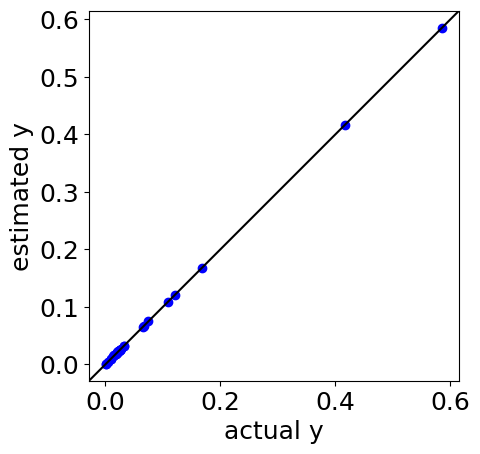

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

r^2 for training data : 0.9999999998401973
RMSE for training data : 1.5632235803256119e-06
MAE for training data : 1.0553548829334433e-06


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

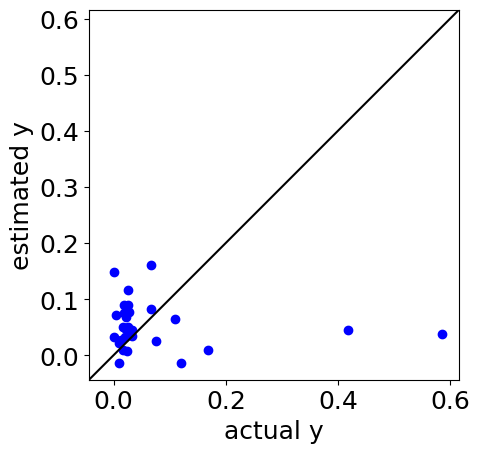

r^2 in cross-validation : -0.20478960159121096
RMSE in cross-validation : 0.13573274521215833
MAE in cross-validation : 0.07577327455578625
     std_of_estimated_y
id                     
0              0.100560
1              0.112483
2              0.120640
3              0.071681
4              0.097723
..                  ...
724            0.105155
725            0.113026
726            0.114100
727            0.116796
728            0.120463

[699 rows x 1 columns]
sample number : 1 / 30
     std_of_estimated_y
id                     
0              0.083692
1              0.104287
2              0.118453
4              0.081698
5              0.108110
..                  ...
724            0.103617
725            0.111520
726            0.112582
727            0.115364
728            0.119032

[698 rows x 1 columns]
sample number : 2 / 30
     std_of_estimated_y
id                     
0              0.082455
1              0.103076
2              0.118179
4              0.07934

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.081715
1              0.092082
2              0.108787
4              0.058160
5              0.093709
..                  ...
724            0.101058
725            0.109509
726            0.110523
727            0.113687
728            0.118198

[696 rows x 1 columns]
sample number : 4 / 30
     std_of_estimated_y
id                     
0              0.081025
1              0.080835
2              0.096990
5              0.066380
6              0.081126
..                  ...
724            0.099931
725            0.108667
726            0.109633
727            0.112961
728            0.117692

[695 rows x 1 columns]
sample number : 5 / 30
     std_of_estimated_y
id                     
0              0.080082
1              0.079837
2              0.096019
5              0.064736
6              0.080019
..                  ...
724            0.098849
725            0.107812
726            0.108340
727            0.1

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.079005
1              0.078687
2              0.095010
5              0.063000
6              0.078798
..                  ...
724            0.097696
725            0.106937
726            0.107276
727            0.111251
728            0.117176

[693 rows x 1 columns]
sample number : 7 / 30
     std_of_estimated_y
id                     
0              0.078280
1              0.078032
2              0.094036
5              0.061348
6              0.077952
..                  ...
724            0.096714
725            0.106210
726            0.106731
727            0.110729
728            0.116863

[692 rows x 1 columns]
sample number : 8 / 30
     std_of_estimated_y
id                     
0              0.077602
1              0.077385
2              0.093135
5              0.059753
6              0.077112
..                  ...
724            0.095745
725            0.105469
726            0.106025
727            0.1

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

sample number : 10 / 30
     std_of_estimated_y
id                     
0              0.075876
1              0.075529
2              0.090774
5              0.055879
6              0.074674
..                  ...
724            0.093778
725            0.103745
726            0.103721
727            0.108242
728            0.115636

[689 rows x 1 columns]
sample number : 11 / 30
     std_of_estimated_y
id                     
0              0.075829
1              0.075532
2              0.090584
5              0.055363
6              0.074579
..                  ...
724            0.093367
725            0.103302
726            0.103128
727            0.107680
728            0.115073

[688 rows x 1 columns]
sample number : 12 / 30


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.075540
1              0.075189
2              0.090032
5              0.054362
6              0.073984
..                  ...
724            0.092764
725            0.102599
726            0.102130
727            0.106753
728            0.114309

[687 rows x 1 columns]
sample number : 13 / 30
     std_of_estimated_y
id                     
0              0.075687
1              0.075588
2              0.091521
5              0.054926
6              0.074021
..                  ...
724            0.092609
725            0.102570
726            0.102880
727            0.107050
728            0.114894

[686 rows x 1 columns]
sample number : 14 / 30


/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.074831
1              0.074588
2              0.089189
5              0.053361
6              0.073263
..                  ...
724            0.091423
725            0.101201
726            0.100724
727            0.105337
728            0.112721

[685 rows x 1 columns]
sample number : 15 / 30
     std_of_estimated_y
id                     
0              0.074443
1              0.074176
2              0.088743
5              0.052825
6              0.072641
..                  ...
724            0.090785
725            0.100447
726            0.099752
727            0.104438
728            0.111926

[684 rows x 1 columns]
sample number : 16 / 30
     std_of_estimated_y
id                     
0              0.073992
1              0.073676
2              0.087977
5              0.051818
6              0.072018
..                  ...
724            0.090066
725            0.099674
726            0.098706
727            0

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.073807
1              0.073795
2              0.089055
5              0.051640
6              0.071725
..                  ...
724            0.089842
725            0.099664
726            0.099096
727            0.103685
728            0.111978

[682 rows x 1 columns]
sample number : 18 / 30
     std_of_estimated_y
id                     
0              0.070579
1              0.070684
2              0.084721
5              0.050110
6              0.069003
..                  ...
724            0.085474
725            0.094192
726            0.093793
727            0.097996
728            0.104999

[681 rows x 1 columns]
sample number : 19 / 30
     std_of_estimated_y
id                     
0              0.073415
1              0.073260
2              0.087194
5              0.050119
6              0.071130
..                  ...
724            0.088956
725            0.098458
726            0.096560
727            0

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.069779
1              0.069837
2              0.083516
5              0.048527
6              0.067814
..                  ...
724            0.084121
725            0.092745
726            0.091415
727            0.095695
728            0.103299

[679 rows x 1 columns]
sample number : 21 / 30
     std_of_estimated_y
id                     
0              0.069376
1              0.069503
2              0.083045
5              0.048120
6              0.067489
..                  ...
724            0.083586
725            0.092093
726            0.090764
727            0.094978
728            0.102442

[678 rows x 1 columns]
sample number : 22 / 30
     std_of_estimated_y
id                     
0              0.072550
1              0.072434
2              0.085986
5              0.048373
6              0.069938
..                  ...
724            0.087472
725            0.096855
726            0.094399
727            0

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.071912
1              0.071771
2              0.085524
5              0.047683
6              0.069185
..                  ...
724            0.086846
725            0.096147
726            0.093771
727            0.098884
728            0.107260

[676 rows x 1 columns]
sample number : 24 / 30
     std_of_estimated_y
id                     
0              0.071745
1              0.071677
2              0.085359
5              0.047539
6              0.068994
..                  ...
724            0.086573
725            0.095823
726            0.093415
727            0.098517
728            0.106813

[675 rows x 1 columns]
sample number : 25 / 30
     std_of_estimated_y
id                     
0              0.068079
1              0.068081
2              0.080849
5              0.046257
6              0.065816
..                  ...
724            0.081655
725            0.089948
726            0.088202
727            0

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamaza

     std_of_estimated_y
id                     
0              0.067648
1              0.067717
2              0.080302
5              0.045837
6              0.065512
..                  ...
724            0.081173
725            0.089352
726            0.087664
727            0.092022
728            0.099229

[673 rows x 1 columns]
sample number : 27 / 30
     std_of_estimated_y
id                     
0              0.067403
1              0.067450
2              0.079876
5              0.045333
6              0.065151
..                  ...
724            0.080153
725            0.088822
726            0.086847
727            0.091368
728            0.098673

[672 rows x 1 columns]
sample number : 28 / 30
     std_of_estimated_y
id                     
0              0.070662
1              0.070544
2              0.083022
5              0.045565
6              0.067678
..                  ...
724            0.084045
725            0.093023
726            0.091115
727            0

/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yamazakihiroto/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [3]:
# remaining_samples_path, date, 出力するremaining_samplesのpathをラウンドごとに調整する

import os
import numpy as np
import pandas as pd

#次の候補の数
number_of_selecting_samples = 30

# 実験日
date = "2024-01-11-2"

# ファイルのパスを定義
generated_samples_path = './../data/generated_samples.csv'
remaining_samples_path = './../data/remaining_samples/remaining_samples_1.csv'

# 実験結果データの読み込み
dataset = pd.read_csv('./../data/result.csv', index_col=0, header=0)

if os.path.exists(remaining_samples_path):
    x_prediction = pd.read_csv(remaining_samples_path, index_col=0, header=0)
elif os.path.exists(generated_samples_path):
    x_prediction = pd.read_csv(generated_samples_path, index_col=0, header=0)


# 実験条件の全候補のインデックスのリスト
all_indexes = x_prediction.index.tolist()

# データ分割
y = dataset.iloc[:, 0]  # 目的変数
x = dataset.iloc[:, 1:]  # 説明変数

# 標準偏差が 0 の特徴量の削除
deleting_variables = x.columns[x.std() == 0]
x = x.drop(deleting_variables, axis=1)
x_prediction = x_prediction.drop(deleting_variables, axis=1)
cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化

# ガウス過程回帰(最初にカーネル関数を選択する)
regression_method = 'gpr_one_kernel'
acquisition_function = 'PTR' #PTR PI EI MI

cumulative_variance = np.zeros(x_prediction.shape[0]) # MI で必要な "ばらつき" を 0 で初期化
relaxation = 0.01 #EI PI
delta = 10**-6 #MI

next_samples = pd.DataFrame([], columns=x_prediction.columns) # 次のサンプルを入れる変数を準備

for sample_number in range(number_of_selecting_samples):
    # オートスケーリング
    autoscaled_y = (y - y.mean()) / y.std()
    autoscaled_x = (x - x.mean()) / x.std()
    autoscaled_x_prediction = (x_prediction - x.mean()) / x.std()

    # モデル構築
    model = gpr_one_kernel(2,autoscaled_x, autoscaled_y, x)

     # クロスバリデーション
    if sample_number == 0:
        validate = validate_model(regression_method, model,10, autoscaled_x, autoscaled_y, x, y)

    # 予測
    estimated_y_prediction, estimated_y_prediction_std = predict(regression_method, model, autoscaled_x_prediction, x_prediction, y)
    estimated_y_prediction, acquisition_function_prediction, acquisition_function = acquisition_functions(x_prediction, estimated_y_prediction, estimated_y_prediction_std, delta, acquisition_function, relaxation, y, regression_method)


    # 保存
    estimated_y_prediction = pd.DataFrame(estimated_y_prediction, x_prediction.index, columns=['estimated_y'])
    estimated_y_prediction_std = pd.DataFrame(estimated_y_prediction_std, x_prediction.index, columns=['std_of_estimated_y'])
    print(estimated_y_prediction_std)
    acquisition_function_prediction = pd.DataFrame(acquisition_function_prediction, index=x_prediction.index, columns=['acquisition_function'])
    if sample_number == 0:
        estimated_y_prediction.to_csv('./../data/estimated_y_prediction_gpr_one_kernel/estimated_y_prediction_{0}_{1}.csv'.format(regression_method,date))  # 予測結果を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        estimated_y_prediction_std.to_csv('./../data/estimated_y_prediction_gpr_one_kernel_std/estimated_y_prediction_{0}_std_{1}.csv'.format(regression_method,date))  # 予測値の標準偏差を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる
        acquisition_function_prediction.to_csv('./../data/acquisiton_function_prediction/acquisition_function_prediction_{0}_{1}_{2}.csv'.format(regression_method, acquisition_function,date))  # 獲得関数を csv ファイルに保存。同じ名前のファイルがあるときは上書きされる

    # 次のサンプル
    next_samples = pd.concat([next_samples, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    
    
    # x, y, x_prediction, cumulative_variance の更新
    x = pd.concat([x, x_prediction.loc[acquisition_function_prediction.idxmax()]], axis=0)
    y = pd.concat([y, estimated_y_prediction.loc[acquisition_function_prediction.idxmax()].iloc[0]], axis=0)
    x_prediction = x_prediction.drop(acquisition_function_prediction.idxmax(), axis=0)
    cumulative_variance = np.delete(cumulative_variance, np.where(acquisition_function_prediction.index == acquisition_function_prediction.iloc[:, 0].idxmax())[0][0])
    print('sample number : {0} / {1}'.format(sample_number + 1, number_of_selecting_samples))

# 実験日の日付
x_prediction.to_csv('./../data/remaining_samples/remaining_samples_2-2.csv')
next_samples.to_csv(f'./../data/next_samples/next_samples_bo_{date}.csv'.format(regression_method, acquisition_function)) # csv ファイルに保存。同じ名前のファイルがあるときは上書きされますので注意してください